In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import imageio

import pandas as pd

from AVIReader import * # Reads an avi file and returns a sidpy dataset with meta data
from MonaPathParse import * # Code written to splice files from Mona's experiments, NOT UNIVERSAL 

from skimage import data,color,io,util
from skimage.filters import threshold_otsu, roberts, sobel, scharr, prewitt
from skimage.segmentation import clear_border, watershed
from skimage.measure import label,regionprops
from skimage.morphology import closing, square, disk, erosion, dilation, opening
from skimage.morphology import white_tophat, black_tophat, skeletonize, convex_hull_image
from skimage.color import label2rgb, rgb2gray
from skimage.feature import canny, peak_local_max
from scipy import ndimage as ndi

In [2]:
#After importing the toolboxes above, specify the location of the video file that you want to import and analyze

# Specifies the path location of the experimental video on the hard drive from Mona.
# This path variable will be analyzed to capture metadate about the experiment.


path = "/Volumes/MK_Device_5/Microbial/8H_Migration_Studies/PGM17_033022/PGM17_R2A/" +\
    "6_H/Channel_3_15.avi"

path_dict = MonaPathParse(path)
path_dict = path_dict.read()
path_dict["Scale_MicronPerPixel"] = float(440/687)

dset = AVIReader(path, path_dict)
dset_read = dset.read()

scale = (dset_read.metadata["Scale_MicronPerPixel"])

dset_read # shows the size and shape of the data set for the imported AVI file
# sidpy.dict_utils.print_nested_dict(dset_read.metadata) #Use this to look at the metadata easily


sidpy.Dataset of type IMAGE_STACK with:
 dask.array<array, shape=(239, 520, 696, 3), dtype=uint8, chunksize=(239, 260, 348, 3), chunktype=numpy.ndarray>
 data contains: generic (generic)
 and Dimensions: 
t:  Time (seconds) of size (263,)
y:  Length (pixel) of size (520,)
x:  Length (generic) of size (696,)
Color Channel:  generic (generic) of size (3,)
 with metadata: ['index', 'codec_name', 'codec_long_name', 'codec_type', 'codec_tag_string', 'codec_tag', 'width', 'height', 'coded_width', 'coded_height', 'closed_captions', 'film_grain', 'has_b_frames', 'pix_fmt', 'level', 'refs', 'r_frame_rate', 'avg_frame_rate', 'time_base', 'start_pts', 'start_time', 'duration_ts', 'duration', 'bit_rate', 'nb_frames', 'extradata_size', 'disposition', 'Species', 'Collection Date', 'Media', 'Timepoint', 'Time_Units', 'Filename', 'Microfluidic Channel Number', 'Channel Location', 'Scale_MicronPerPixel']

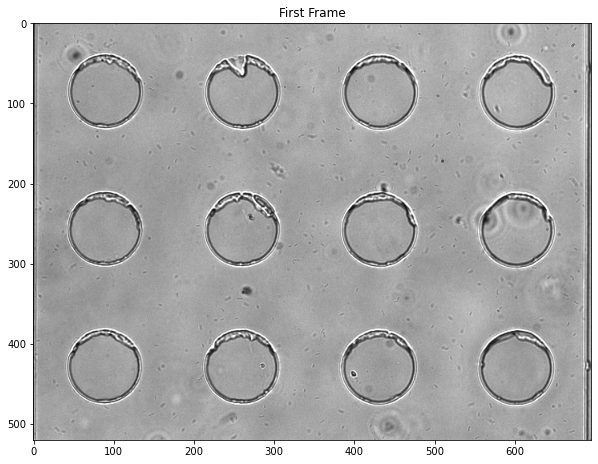

In [3]:
# 1 - Take a peak at the first frame of the avi file that you plan to do analysis on.

# This command reads in the first frame of the AVI file that we want to import.
# Data is captured as a numpy array with RGB values for each pixel in the image.
 
#vidcap = cv2.VideoCapture(path) 
#success, image = vidcap.read() #captures a boolean in the variable 'success' and np in image

img = np.array(dset_read[1,:,:,:])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
height, width = gray.shape
plt.figure(figsize=(10,10))
plt.title('First Frame')
plt.imshow(gray, cmap = 'gray')

In [4]:
video = np.array(dset_read[:,:,:,:])



In [ ]:
video = np.array(dset_read[:,:,:,:])

kernelclosing = np.ones((3,3), np.uint8)
kernel = np.ones((3,3), np.uint8)

mean_image = np.array(video.mean(axis = 0), dtype='uint8')
clean_video = np.array((np.divide(video,mean_image)*200), dtype='uint8')

masks = []
new_video = []
object_count = []

for i in range(video.shape[0]):
    vid = video[i,:,:,:]
    
    frame = clean_video[i,:,:,:]
    roi = frame [0:520,0:696]
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(gray, (3,3), 0)
    canny = cv2.Canny(gray, 70, 100)
    closing = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, (kernelclosing))
    #dilation = cv2.dilate(closing, kernel, iterations = 1)
    #opening = cv2.morphologyEx(canny, cv2.MORPH_OPEN, kernel)
    
    
    mask = closing
    masks.append(mask)
    #ret, thresh1 = cv2.threshold(image, 127,255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    detections = []
    
    for cnt in contours:
        #calculate the area of the object
        area = cv2.contourArea(cnt)
       
        if area > 2 and area < 40:
            #cv2.drawContours(roi, [cnt], -1, (0,255,0), 2)
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(vid, (x-2, y-2), (x + w+2, y + h+2), (0, 255, 0), 1)
            detections.append([x, y, w, h])
        
        if area >=40 and area < 50:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(vid, (x-2, y-2), (x + w+2, y + h+2), (0, 0, 255), 1)
            detections.append([x, y, w, h])
            
    new_video.append(vid)
    object_count.append(len(detections))


    cv2.imshow("Frame", vid)
    cv2.imshow("Mask", mask)   
    key = cv2.waitKey(80)
    if key == 27:
        break


video = np.array(dset_read[:,:,:,:])
box_video = np.stack(new_video, axis = 0)
mask_video = np.stack(masks, axis=0)
print(box_video.shape)
print(mask_video.shape)
    
plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
plt.title('Video')
plt.imshow(video[1,:,:,:], cmap='gray')

plt.subplot(2,2,2)
plt.title('Clean')
plt.imshow(clean_video[1,:,:,:], cmap='winter')

plt.subplot(2,2,3)
plt.title('Mask')
plt.imshow(mask_video[1], cmap='gray')
    
plt.subplot(2,2,4)
plt.title('Moving Objects')
plt.imshow(box_video[1], cmap='gray')    


plt.savefig("/Volumes/MK_Device_5/FiguresOutput/ImageProcessing.png", dpi='figure', format='png')
    


(239, 520, 696, 3)
(239, 520, 696)


In [ ]:
imageio.mimwrite('/Volumes/MK_Device_5/FiguresOutput/mask.tiff',mask_video)
imageio.mimwrite('/Volumes/MK_Device_5/FiguresOutput/box_vid.tiff',box_video)

In [ ]:
print('Min : ' + str(min(object_count)))
print('Max : ' + str(max(object_count)))
print('AVG : ' + str(int(sum(object_count)/len(object_count))))

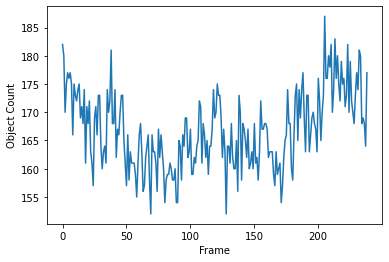

In [7]:
plt.plot(object_count)
plt.xlabel("Frame")
plt.ylabel('Object Count')
plt.show()

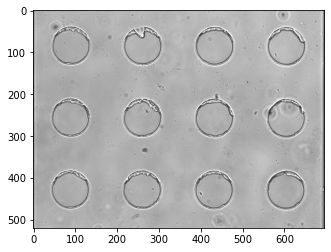

In [8]:
video.shape
plt.imshow(mean_image)

In [9]:
clean_video.shape
frame = 10

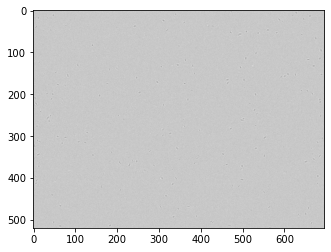

In [10]:
image = clean_video[frame,:,:,:]
plt.imshow(image)